In [7]:
import IPython.core.display as di
di.display_html('<script>jQuery(function() {if (jQuery("body.notebook_app").length == 0) { jQuery(".input_area").toggle(); jQuery(".prompt").toggle();}});</script>', raw=True)

This is a simple attempt to find the time constant for appropriate deconvolution using the data from June 2017. 
The base code is based on TimeConstant, but the Model is now modified to the first order for greater accuracy. 

The model will be an integral over a frequency weighted gaussian times the wave function. 

To clarify, the model will now be 

$$\int \frac{1}{\sqrt{2 \pi p}} e^{\frac{-(q-q_0)^2}{2p^2}}cos{(2 \pi q(z-z_0))}dq$$



Mira

The notebook this is in is TimeConstant6. (see pages 80-81)

In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as pl
%matplotlib inline
import pickle
import seaborn as sns
import sys
import numpy as np
import scipy.optimize as op
from scipy.optimize import curve_fit
from scipy.special import erf

sns.set_palette("PuBuGn_d",15)
sns.set_style("whitegrid")
import emcee
from scipy.integrate import quad

In [3]:
with open('../../../data/raw_data/20170615_1730_20mms_reference.pkl', 'rb') as f:
    d = pickle.load(f, encoding='latin1') 

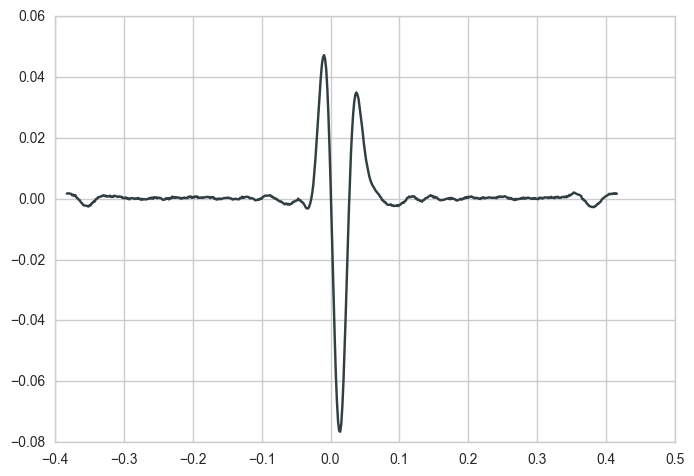

In [4]:
i = 9
Nsize = 2**i
dt=(1/(d['sample freq'])) #period
T1=dt*(Nsize) #full period
v=(d['speed'])
X = v*T1 #full distance
dx = dt*v #smallest amount of distance travelled
total_t = (d['scan time']) #how long it ran
    
total_s = (d['samples requested']) #number of samples 
startpt = ((total_s - Nsize)/2) #starting point


endpt = startpt + Nsize #ending point


df = 1/T1
f = df*np.arange(Nsize/2)+df/2.0
fFull = df*np.arange((Nsize/2) + 1)+df/2.0

startpt = int(startpt)
endpt = int(endpt)
F = (d['sig0F']) 
D = F[startpt:endpt]
#D = np.flipud(D)

a = d['delay0F']/v
t = a[startpt:endpt]

pl.plot(t,D)
pl.show()

In [5]:
#model function convoluted with RC circuit and AC coupling function 
#added the integral for first order
def psi1(znot,qnot,p,T): #znot,qnot,p,T
    Ns = Nsize
    z = t
    q = np.linspace(-50,50,num=Nsize)
    qmin = np.amin(q)
    qmax = np.amax(q)
    dz = z[2]-z[1]
    f = np.linspace(0,0.5/dz, np.floor(Ns/2))
    f_full = np.linspace(0,0.5/dz, np.floor(Ns/2) +1)
    #original function
    y0 = (1/(np.sqrt(2*np.pi*np.sqrt(p))))*(np.pi/2)*p*np.cos(2*q*(z-znot))*(erf((qnot-qmin)/np.sqrt(2)*p)-erf((qnot-qmax)/(np.sqrt(2)*p)))
    yf0=np.fft.rfft(y0)
    K_det =(1/(1+(1j*2*np.pi*f_full*T))) #kernel from detector
    K_cc =(2*np.pi*f_full*.559)/(1 + (1j*2*np.pi*.559)) #kernel from AC coupling
    K_f = np.multiply(K_det,K_cc)
    y1=np.fft.irfft(yf0*K_f*2*np.pi)
    return t,y1
#znot = 0.012, q = 8.57718120805, p = .04

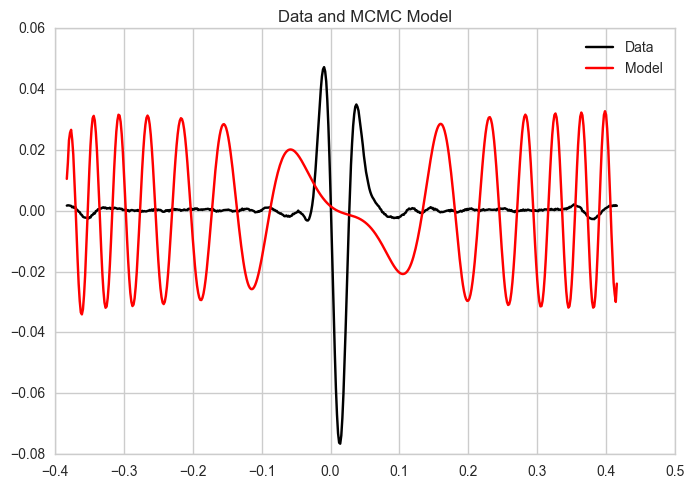

In [6]:
#VISUAL COMPARISON TO GUESS PARAMETERS BY EYE to put into optimals above.
#NO Model shift
pl.plot(t,D, label = 'Data', color = 'black')
x,Modelf = psi1(0.01,10,.006,.02 ) #znot,qnot,p,T,
#x,Modelf = psi1(0.098,9.99,-1034,10 )

pl.plot(x,Modelf*(-.04), label = 'Model', color = 'red')
#pl.xlim(-.2,.2)
pl.title('Data and MCMC Model')
pl.legend()
pl.show()

The graph above is the new model superimposed upon the Data. I am not sure how to continue form this as the numbers recommended by the 'best fit" and MCMC do not seem to be logical. 

The range of q used here is from -50 to 50. I am not sure about what the range should be. Essentially I will not continue to work on this until I speak to Rito. 